# App

## Package

In [1]:
from typing import Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle

from utils import get_data, get_metrics
from classic_CV import create_result_classic
from classic_model import create_data
from NN_model import get_NN_model

## Import data

In [2]:
data = get_data(path='../data/HRF/')

In [3]:
create = False
MLdata = create_data() if create else pd.read_csv('../data/for_CML/test_data.csv')

In [4]:
features_classic_ml = ['ch_avg_B', 'ch_avg_G', 'ch_avg_R', 'ch_std_B',
       'ch_std_G', 'ch_std_R', 'hu_mom1', 'hu_mom2', 'hu_mom3', 'hu_mom4',
       'hu_mom5', 'hu_mom6', 'hu_mom7', 'sp_mom_00', 'sp_mom_10', 'sp_mom_01',
       'sp_mom_20', 'sp_mom_11', 'sp_mom_02', 'sp_mom_30', 'sp_mom_21',
       'sp_mom_12', 'sp_mom_03', 'nu_mom_20', 'nu_mom_11', 'nu_mom_02',
       'nu_mom_30', 'nu_mom_21', 'nu_mom_12', 'nu_mom_03']

## Import models

In [5]:
classic_model = pickle.load(open('../trained/RFC_model','rb'))
NN_model = get_NN_model()
NN_model.load_weights('../trained/NN_model.h5')

In [6]:
def final_function(model: str='classic_CV', index: int=0, filter_: float = 0.01) -> Union[Tuple[None, None], Tuple[np.ndarray, Tuple[float, float, float]]]:
    models = ['classic_CV', 'classic_ML', 'NN']
    dim = (876, 584)
    if model in models:
        if model == 'classic_CV':
            result = create_result_classic(data['original'][index][:, :, 1], data['mask'][index])
            metrics = get_metrics(result, data['labeled'][index])
        else:
            if index not in [0, 1, 2, 3, 4]:
                print('Wrong index. Choose between 0 and 4!')
                return None, None
            image = MLdata.loc[MLdata.id == index]
            if model == 'classic_ML':
                result = classic_model.predict_proba(image.drop(['Unnamed: 0', 'id', 'label'], axis=1))[:,1]
            else:
                result = NN_model.predict(image.drop(['Unnamed: 0', 'id', 'label'], axis=1))
            result = np.where(result > filter_, 255, 0)
            result = np.pad(result.reshape(dim[1]-4, dim[0]-4), 2)
            label = cv2.resize(data['labeled'][index], dim, interpolation=cv2.INTER_AREA)
            label = np.where(label > 190, 255, 0)
            metrics = get_metrics(result, label)
    else:
        print('Wrong model')
        return None, None
    return result, metrics

### Filter check

In [7]:
def check_filter() -> pd.DataFrame:
    result = {'model': [], 'filter': [], 'index': [], 'accuracy': [], 'sensitivity': [], 'specificity': []}
    for model in ('classic_ML', 'NN'):
        for filter_ in (0.005, 0.01, 0.05, 0.1, 0.2, 0.3):
            for index in range(5):
                _, metric = final_function(model=model, index=index, filter_=filter_)
                result['model'].append(model)
                result['filter'].append(filter_)
                result['index'].append(index)
                result['accuracy'].append(metric[0])
                result['sensitivity'].append(metric[1])
                result['specificity'].append(metric[2])
    return pd.DataFrame(result)

In [8]:
filter_check_df = check_filter()

In [9]:
metrics_avg = filter_check_df.drop('index', axis=1).groupby(['model', 'filter']).mean()

In [10]:
metrics_avg = metrics_avg.reset_index()
metrics_avg

,model,filter,accuracy,sensitivity,specificity
0,NN,0.005,0.877993,0.197956,0.941517
1,NN,0.010,0.880022,0.192795,0.944216
2,NN,0.050,0.891177,0.155680,0.959883
3,NN,0.100,0.900187,0.114898,0.973569
4,NN,0.200,0.910246,0.049687,0.990698
5,NN,0.300,0.913523,0.019250,0.997133
6,classic_ML,0.005,0.914289,0.042626,0.995781
7,classic_ML,0.010,0.914289,0.042626,0.995781
8,classic_ML,0.050,0.914289,0.042626,0.995781
9,classic_ML,0.100,0.914289,0.042626,0.995781


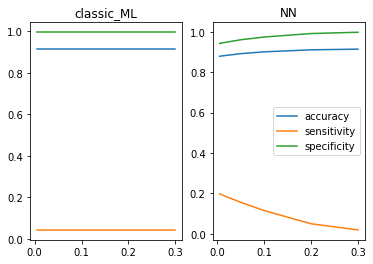

In [11]:
for model, place in zip(('classic_ML', 'NN'), (1, 2)):
    plt.subplot(1, 2, place)
    plt.plot(metrics_avg.loc[metrics_avg['model']==model, 'filter'], metrics_avg.loc[metrics_avg['model']==model, 'accuracy'], label = 'accuracy')
    plt.plot(metrics_avg.loc[metrics_avg['model']==model, 'filter'], metrics_avg.loc[metrics_avg['model']==model, 'sensitivity'], label = 'sensitivity')
    plt.plot(metrics_avg.loc[metrics_avg['model']==model, 'filter'], metrics_avg.loc[metrics_avg['model']==model, 'specificity'], label = 'specificity')
    plt.title(model)
plt.legend()
plt.show()

## Results

In [12]:
def show_results(model, start=0, stop=5):
    metrics_summary = np.array([0.0, 0.0, 0.0])
    plt.figure(figsize=(5*2, 5*(stop-start)))
    num = stop-start

    for index in range(start, stop):
        new_plot, metric = final_function(model=model, index=index)
        print(f'{metric = }')
        metrics_summary += metric
        plt.subplot(num, 2, index*2+1)
        plt.imshow(new_plot, cmap='gray')
        plt.subplot(num, 2, index*2+2)
        plt.imshow(data['labeled'][index], cmap='gray')
    metrics_summary = metrics_summary/5
    print(f'accuracy:{metrics_summary[0]}, sensitivity:{metrics_summary[1]}, specificity:{metrics_summary[2]}')

### Classic test

metric = (0.9503734968255457, 0.558462287501439, 0.9948286434687224)
metric = (0.9519360456933759, 0.5433428413805388, 0.9967139339988879)
metric = (0.9413011841652593, 0.4980021315225806, 0.993626977534884)
metric = (0.9583181843059986, 0.6871116030176218, 0.9865445834850224)
metric = (0.9631325207590542, 0.6739394087056333, 0.991823873526534)
accuracy:0.9530122863498468, sensitivity:0.5921716544255626, specificity:0.9927076024028102


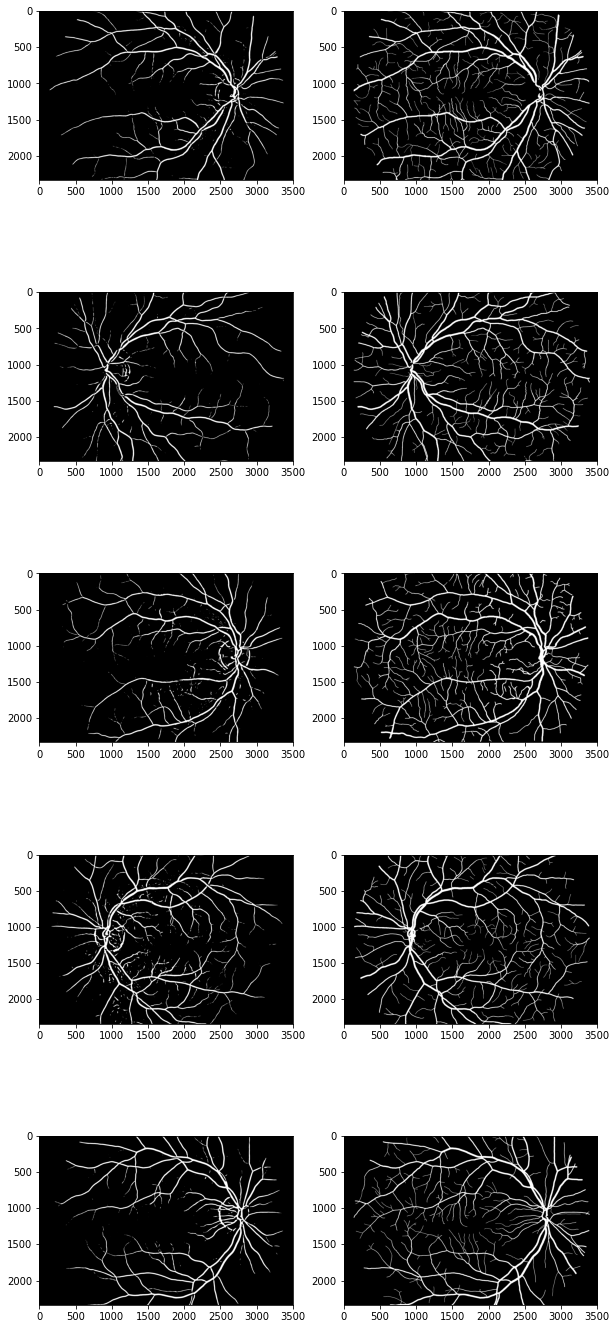

In [13]:
show_results('classic_CV')

### ML test

metric = (0.9130269906799274, 0.07608865129747187, 0.9935395948908159)
metric = (0.9120379057984612, 0.08971598250107668, 0.9896441887876577)
metric = (0.907033839994996, 0.004731065225619244, 0.9995108032739545)
metric = (0.9178746794270345, 0.025710612769604343, 0.9976830260361431)
metric = (0.9214733064364796, 0.016883731354433846, 0.9985278738807917)
accuracy:0.9142893444673797, sensitivity:0.0426260086296412, specificity:0.9957810973738725


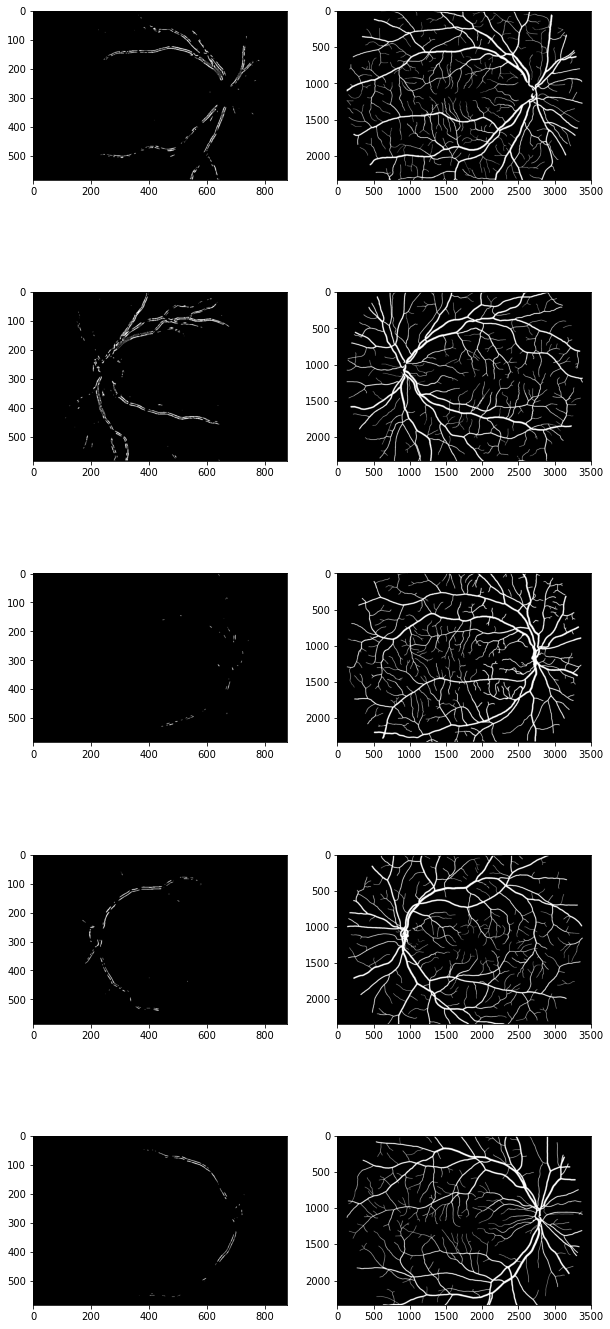

In [14]:
show_results('classic_ML')

### Neural Network

metric = (0.8602047757553012, 0.23644058358391803, 0.9202102470810325)
metric = (0.827822996809908, 0.2949656594963393, 0.8781111821797046)
metric = (0.8953016513417151, 0.13070356196644098, 0.9736652687564921)
metric = (0.906384875211109, 0.14059896205304004, 0.9748880910093743)
metric = (0.9103939919934947, 0.16126702691934158, 0.974205974625976)
accuracy:0.8800216582223056, sensitivity:0.19279515880381598, specificity:0.944216152730516


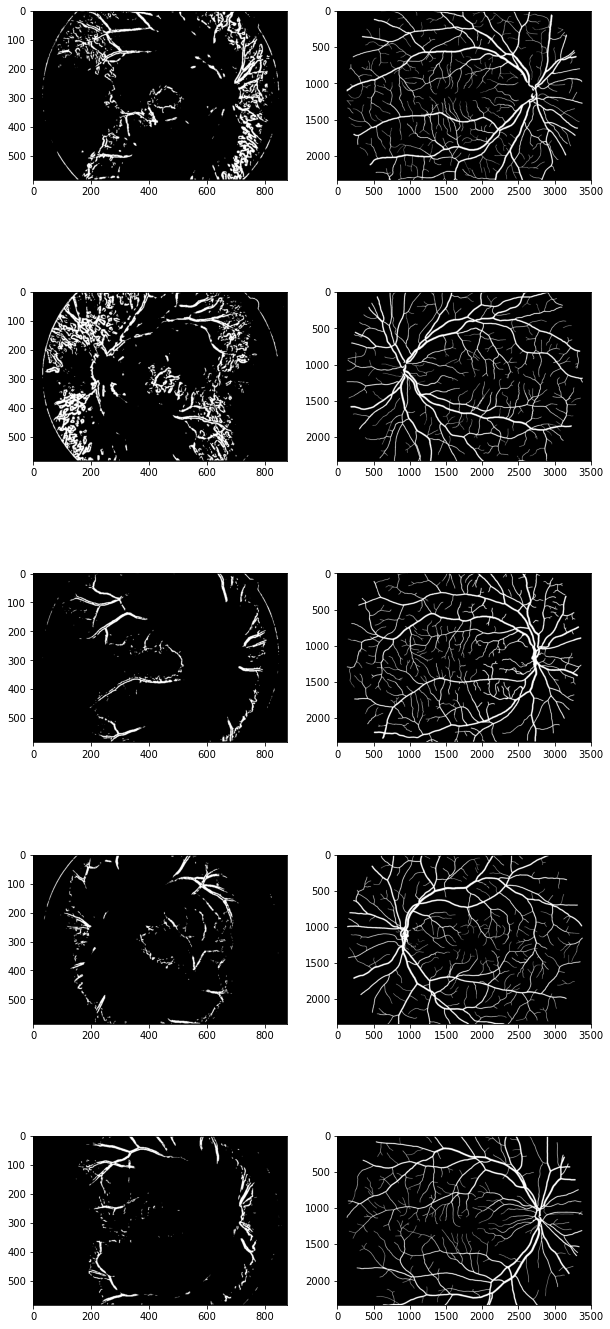

In [15]:
show_results('NN')

# Type here to test

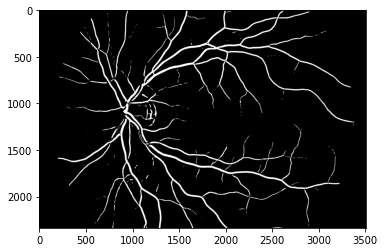

In [16]:
new_plot, metric = final_function(model='classic_CV', index=1)
plt.imshow(new_plot, cmap='gray')